# Import libraries

In [11]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
from matplotlib import pyplot

# Transform a time series dataset into a supervised learning dataset
This steps includes converting a naive time series data into a supervised dataset. The number of values to be used as lag for supervised dataset is sent as a parameter to the function.

In [12]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# Split a univariate dataset into train/test sets


In [13]:
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

# Fit an support vector regressor and make a one step prediction


In [14]:
def support_vector_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model =  SVR()
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

# Walk-forward validation for univariate data


In [15]:
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = support_vector_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

# load the dataset


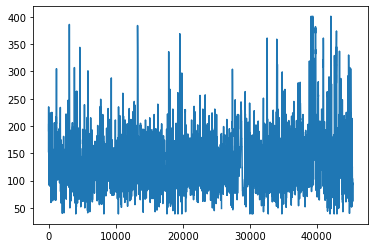

In [16]:
series = read_csv(
    r'C:\Users\ahtis\OneDrive\Desktop\ARIMA\data\data.csv', header=0, index_col=0)
values = series.values
pyplot.plot(values, label='Original Glucose Data')

# Transform the time series data into supervised learning


In [17]:
data = series_to_supervised(values, n_in=6)
data.shape

(44947, 7)

# Evaluate


In [8]:
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)

>expected=83.0, predicted=82.9
>expected=83.0, predicted=83.8
>expected=83.0, predicted=83.6
>expected=84.0, predicted=83.5
>expected=86.0, predicted=84.6
>expected=87.0, predicted=87.0
>expected=86.0, predicted=88.1
>expected=87.0, predicted=86.7
>expected=88.0, predicted=87.8
>expected=90.0, predicted=88.9
>expected=92.0, predicted=91.2
>expected=95.0, predicted=93.5
MAE: 0.795


# Plot expected vs predicted


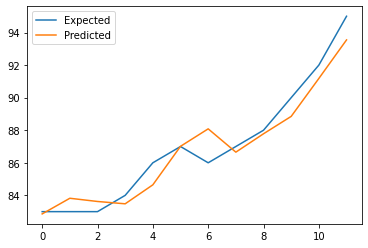

In [18]:
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()